Cấu trúc của dataset: (2365, 4)
Các trường của dataset: ['index', 'user', 'item', 'rating']
Tổng số lượng người dùng: 74
Số người dùng đánh giá không khách quan: 8
Tỉ lệ phần trăm: 10.81%

 Các người dùng đánh giá không khách quan:
Người dùng 14: 5 lượt đánh giá, giá trị 5.0
Người dùng 16: 2 lượt đánh giá, giá trị 5.0
Người dùng 17: 1 lượt đánh giá, giá trị 3.0
Người dùng 44: 1 lượt đánh giá, giá trị 4.5
Người dùng 60: 1 lượt đánh giá, giá trị 4.0
Người dùng 63: 1 lượt đánh giá, giá trị 3.0
Người dùng 65: 1 lượt đánh giá, giá trị 1.0
Người dùng 71: 11 lượt đánh giá, giá trị 5.0
Training set size: 1892
Test set size: 473

Đánh giá thuật toán với N từ 2 đến 16...

N = 2
RMSE: 1.0418

N = 3
RMSE: 0.9061

N = 4
RMSE: 0.9201

N = 5
RMSE: 0.9581

N = 6
RMSE: 1.2030

N = 7
RMSE: 1.2414

N = 8
RMSE: 1.1961

N = 9
RMSE: 1.2415

N = 10
RMSE: 1.2615

N = 11
RMSE: 1.2419

N = 12
RMSE: 1.2099

N = 13
RMSE: 1.0991

N = 14
RMSE: 1.0995

N = 15
RMSE: 1.1168

N = 16
RMSE: 1.0548


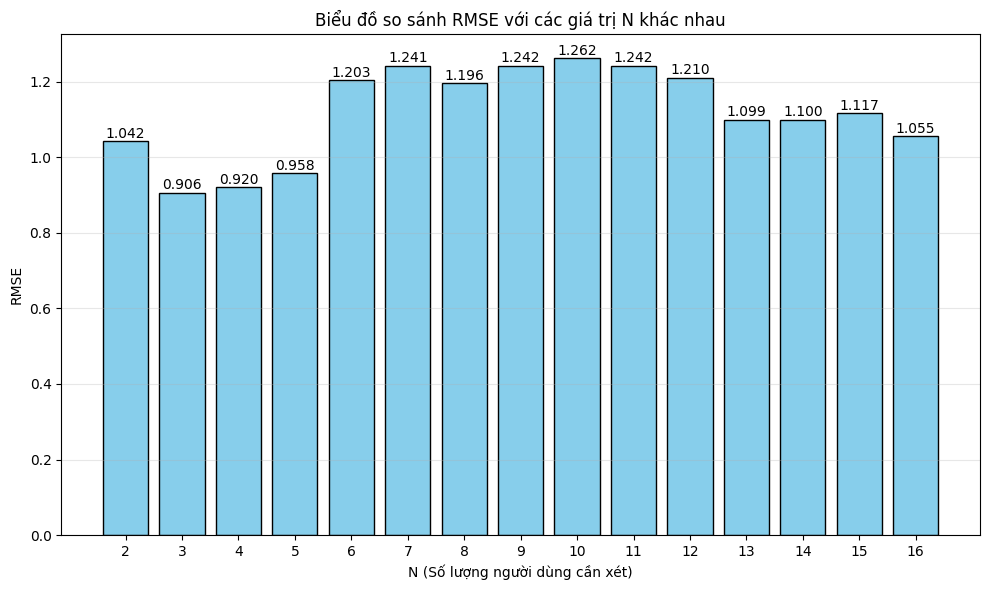


Với N = 3 có giá trị RMSE tốt nhất = 0.9061

--- DEMO PREDICTION FOR SPECIFIC USERS ---

Recommendations for User 1:
User has already rated 5 items
Sample of user's ratings:
     user  item  rating
32      1   167     3.5
130     1   422     3.5
390     1   352     5.0

Top 5 recommended items:
    item  predicted_rating
14    82             5.871
9     37             5.871
10    67             5.871
7     34             5.871
5     28             5.871

Recommendations for User 2:
User has already rated 29 items
Sample of user's ratings:
     user  item  rating
50      2   413     3.5
139     2   183     5.0
238     2   434     4.0

Top 5 recommended items:
    item  predicted_rating
1     25             3.836
6    174             3.836
4    140             3.836
11   376             3.836
10   356             3.836

Recommendations for User 3:
User has already rated 27 items
Sample of user's ratings:
     user  item  rating
78      3   162     5.0
145     3   241     3.5
161     3  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

class CollaborativeFiltering:
    """
    Lớp triển khai thuật toán Collaborative Filtering sử dụng hệ số tương quan Pearson
    để đo độ tương đồng giữa các người dùng và gợi ý sản phẩm.
    """

    def __init__(self, N, data_frame):
        """
        Hàm khởi tạo cho CollaborativeFiltering

        Tham số:
        - N: Số lượng người dùng tương tự cần xem xét
        - data_frame: DataFrame chứa dữ liệu ratings
        """
        self.N = N
        self.data = data_frame
        self.user_item_matrix = None
        self.user_similarity_matrix = None
        self.valid_users = None
        self.user_means = None

        # Loại bỏ users không khách quan
        self._remove_constant_rating_users()

        # Xây dựng ma trận user-item
        self._build_user_item_matrix()

        # Calculate user means for normalization
        self._calculate_user_means()

        # Tính ma trận độ tương đồng
        self._calculate_user_similarity()

    def _remove_constant_rating_users(self):
        """
        Loại bỏ các users có constant ratings (đánh giá tất cả items với cùng một rating value)
        """
        # Tính độ lệch chuẩn của ratings cho mỗi user
        user_ratings_std = self.data.groupby('user')['rating'].std()

        # Tìm users có std = 0 (constant ratings) hoặc NaN (chỉ có 1 rating)
        constant_users = user_ratings_std[user_ratings_std.fillna(0) == 0].index.tolist()

        # Lưu lại danh sách users hợp lệ
        self.valid_users = list(set(self.data['user'].unique()) - set(constant_users))

        # Cập nhật data chỉ giữ lại valid users
        self.data = self.data[self.data['user'].isin(self.valid_users)]

    def _build_user_item_matrix(self):
        """
        Xây dựng ma trận user-item từ dữ liệu
        """
        self.user_item_matrix = self.data.pivot(
            index='user',
            columns='item',
            values='rating'
        )

    def _calculate_user_means(self):
        """
        Calculate mean rating for each user for normalization
        """
        self.user_means = self.user_item_matrix.mean(axis=1)

    def _calculate_user_similarity(self):
        """
        Tính ma trận độ tương đồng giữa người dùng sử dụng hệ số tương quan Pearson
        với dữ liệu đã được chuẩn hóa
        """
        users = self.user_item_matrix.index
        n_users = len(users)

        # Khởi tạo ma trận độ tương đồng
        self.user_similarity_matrix = pd.DataFrame(
            np.zeros((n_users, n_users)),
            index=users,
            columns=users
        )

        # Tính hệ số tương quan Pearson giữa các cặp người dùng
        for i, user_i in enumerate(users):
            for j, user_j in enumerate(users):
                if i < j:  # Chỉ tính nửa trên của ma trận (ma trận đối xứng)
                    # Tìm các sản phẩm được đánh giá bởi cả hai người dùng
                    common_items = self.user_item_matrix.loc[user_i].notna() & \
                                   self.user_item_matrix.loc[user_j].notna()

                    if common_items.sum() > 1:  # Cần ít nhất 2 sản phẩm chung
                        # Get ratings
                        user_i_ratings = self.user_item_matrix.loc[user_i, common_items]
                        user_j_ratings = self.user_item_matrix.loc[user_j, common_items]

                        # Normalize ratings by subtracting user mean
                        user_i_ratings_norm = user_i_ratings - self.user_means[user_i]
                        user_j_ratings_norm = user_j_ratings - self.user_means[user_j]

                        # Calculate standard deviations after normalization
                        std_i = np.std(user_i_ratings_norm)
                        std_j = np.std(user_j_ratings_norm)

                        # Check if either array is constant after normalization
                        if std_i > 1e-10 and std_j > 1e-10:  # Using a small epsilon instead of 0
                            # Tính hệ số tương quan Pearson trên dữ liệu đã chuẩn hóa
                            try:
                                correlation, _ = pearsonr(user_i_ratings_norm, user_j_ratings_norm)
                            except Exception:
                                correlation = np.nan  # Handle any other calculation errors
                            # Xử lý giá trị NaN
                            if not np.isnan(correlation):
                                self.user_similarity_matrix.loc[user_i, user_j] = correlation
                                self.user_similarity_matrix.loc[user_j, user_i] = correlation

        # Đặt đường chéo là 1 (người dùng hoàn toàn tương đồng với chính họ)
        np.fill_diagonal(self.user_similarity_matrix.values, 1)

    def predict(self, user_ratings, num_recommendations):
        """
        Dự đoán và gợi ý các sản phẩm cho người dùng
        sử dụng dữ liệu chuẩn hóa

        Tham số:
        - user_ratings: Vector ratings của người dùng (dict hoặc Series)
        - num_recommendations: Số lượng sản phẩm cần gợi ý

        Trả về:
        - DataFrame với các sản phẩm được sắp xếp theo điểm dự đoán giảm dần
        """
        # Xác định user_id từ user_ratings
        if isinstance(user_ratings, dict):
            user_id = user_ratings.get('user')
        else:
            user_id = user_ratings.name if hasattr(user_ratings, 'name') else user_ratings.index[0]

        # Kiểm tra xem user có trong danh sách valid users không
        if user_id not in self.valid_users:
            print(f"User {user_id} has constant ratings or not in training data")
            return pd.DataFrame(columns=['user', 'item', 'predicted_rating'])

        if user_id not in self.user_similarity_matrix.index:
            # Trả về DataFrame rỗng nếu user không có trong dữ liệu
            return pd.DataFrame(columns=['user', 'item', 'predicted_rating'])

        # Lấy N người dùng tương tự nhất
        similarities = self.user_similarity_matrix.loc[user_id]
        top_similar_users = similarities.nlargest(self.N + 1).index[1:]  # Loại trừ chính user

        # Get the user's mean for denormalization later
        user_mean = self.user_means[user_id]

        # Lấy các sản phẩm chưa được đánh giá bởi người dùng
        user_rated_items = self.user_item_matrix.loc[user_id].notna()
        unrated_items = ~user_rated_items

        # Dự đoán rating cho các sản phẩm chưa được đánh giá
        predictions = []
        for item in self.user_item_matrix.columns[unrated_items]:
            weighted_sum = 0
            similarity_sum = 0

            for similar_user in top_similar_users:
                if not pd.isna(self.user_item_matrix.loc[similar_user, item]):
                    similarity = self.user_similarity_matrix.loc[user_id, similar_user]
                    rating = self.user_item_matrix.loc[similar_user, item]

                    # Normalize rating by subtracting similar user's mean
                    rating_norm = rating - self.user_means[similar_user]

                    # Tính tổng trọng số của các rating
                    weighted_sum += similarity * rating_norm
                    similarity_sum += abs(similarity)

            if similarity_sum > 0:
                # Predict normalized rating
                predicted_rating_norm = weighted_sum / similarity_sum
                # Denormalize by adding target user's mean
                predicted_rating = predicted_rating_norm + user_mean

                predictions.append({
                    'user': user_id,
                    'item': item,
                    'predicted_rating': predicted_rating
                })

        # Chuyển đổi sang DataFrame và sắp xếp
        predictions_df = pd.DataFrame(predictions)

        if not predictions_df.empty:
            # Sắp xếp theo điểm dự đoán giảm dần
            predictions_df = predictions_df.sort_values(
                'predicted_rating',
                ascending=False
            ).head(num_recommendations)

        return predictions_df

def calculate_rmse_manual(actual_ratings, predicted_ratings):
    """
    Tính RMSE
    """
    # Chuyển sang numpy array nếu cần
    if isinstance(actual_ratings, pd.Series):
        actual_ratings = actual_ratings.values
    if isinstance(predicted_ratings, pd.Series):
        predicted_ratings = predicted_ratings.values

    # Tính sai số
    errors = actual_ratings - predicted_ratings
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)

    return rmse

def analyze_constant_rating_users(data):
    """
    Phân tích và thống kê users có constant ratings
    """
    # Tính độ lệch chuẩn của ratings cho mỗi user
    user_ratings_std = data.groupby('user')['rating'].std()

    # Tìm users có std = 0 (constant ratings) hoặc NaN (chỉ có 1 rating)
    constant_users = user_ratings_std[user_ratings_std.fillna(0) == 0].index.tolist()

    print(f"Tổng số lượng người dùng: {len(data['user'].unique())}")
    print(f"Số người dùng đánh giá không khách quan: {len(constant_users)}")
    print(f"Tỉ lệ phần trăm: {len(constant_users) / len(data['user'].unique()) * 100:.2f}%")

    # Hiển thị một vài ví dụ
    print("\n Các người dùng đánh giá không khách quan:")
    for i, user in enumerate(constant_users[:80]):
        user_data = data[data['user'] == user]
        print(f"Người dùng {user}: {len(user_data)} lượt đánh giá, giá trị {user_data['rating'].iloc[0]}")

    return constant_users

def main():
    # Load dataset và xây dựng utility matrix
    data = pd.read_csv('ratings2k.csv')

    print(f"Cấu trúc của dataset: {data.shape}")
    print(f"Các trường của dataset: {data.columns.tolist()}")

    # Phân tích users có constant ratings
    constant_users = analyze_constant_rating_users(data)

    # Chia dataset thành training và test sets với tỷ lệ 8:2
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

    print(f"Training set size: {len(train_data)}")
    print(f"Test set size: {len(test_data)}")

    # Đánh giá thuật toán với N trong khoảng [2, 16]
    print("\nĐánh giá thuật toán với N từ 2 đến 16...")
    N_values = list(range(2, 17))
    rmse_values = []

    for N in N_values:
        print(f"\nN = {N}")

        # Khởi tạo model với training data (sẽ tự động loại bỏ constant rating users)
        cf_model = CollaborativeFiltering(N, train_data)

        # Dự đoán cho test set
        test_users = test_data['user'].unique()
        all_predictions = []

        for user in test_users:
            # Bỏ qua users có constant ratings
            if user not in cf_model.valid_users:
                continue

            # Lấy tất cả ratings của user trong test set
            user_test_ratings = test_data[test_data['user'] == user]

            # Dự đoán cho các items trong test set
            predictions = cf_model.predict(
                {'user': user},
                num_recommendations=len(user_test_ratings)
            )

            if not predictions.empty:
                # Chỉ giữ lại các predictions cho items có trong test set
                merged = pd.merge(
                    user_test_ratings,
                    predictions,
                    on=['user', 'item'],
                    how='inner'
                )
                if not merged.empty:
                    all_predictions.append(merged)

        # Tính RMSE
        if all_predictions:
            all_predictions_df = pd.concat(all_predictions, ignore_index=True)

            if not all_predictions_df.empty:
                actual = all_predictions_df['rating']
                predicted = all_predictions_df['predicted_rating']

                rmse = calculate_rmse_manual(actual, predicted)
                rmse_values.append(rmse)
                print(f"RMSE: {rmse:.4f}")
            else:
                rmse_values.append(None)
                print("Không có giá trị dự đoán hợp lệ")
        else:
            rmse_values.append(None)
            print("Không dự đoán được")

    # Vẽ bar chart cho RMSE values với mỗi N
    plt.figure(figsize=(10, 6))
    valid_N = [N for N, rmse in zip(N_values, rmse_values) if rmse is not None]
    valid_rmse = [rmse for rmse in rmse_values if rmse is not None]

    bars = plt.bar(valid_N, valid_rmse, color='skyblue', edgecolor='black')
    plt.xlabel('N (Số lượng người dùng cần xét)')
    plt.ylabel('RMSE')
    plt.title('Biểu đồ so sánh RMSE với các giá trị N khác nhau')
    plt.xticks(valid_N)
    plt.grid(axis='y', alpha=0.3)
    for bar, rmse in zip(bars, valid_rmse):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{rmse:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    best_N = valid_N[np.argmin(valid_rmse)]
    best_rmse = min(valid_rmse)
    print(f"\nVới N = {best_N} có giá trị RMSE tốt nhất = {best_rmse:.4f}")

    # Tạo model cuối cùng với toàn bộ dataset để deploy
    final_model = CollaborativeFiltering(best_N, data)

    # Demo the prediction functionality
    print("\n--- DEMO PREDICTION FOR SPECIFIC USERS ---")

    # Choose a few users to demonstrate (pick from valid users)
    demo_users = list(final_model.valid_users)[:3]  # Get first 3 valid users

    for user_id in demo_users:
        print(f"\nRecommendations for User {user_id}:")

        # Get items user has already rated
        user_rated_items = data[data['user'] == user_id]
        print(f"User has already rated {len(user_rated_items)} items")

        if len(user_rated_items) > 0:
            print("Sample of user's ratings:")
            print(user_rated_items[['user', 'item', 'rating']].head(3))

        # Get recommendations for this user
        recommendations = final_model.predict({'user': user_id}, num_recommendations=5)

        if not recommendations.empty:
            print("\nTop 5 recommended items:")
            print(recommendations[['item', 'predicted_rating']].round(3))


        else:
            print("No recommendations available for this user.")

    return final_model

if __name__ == "__main__":
    model = main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')